## load base files

In [1]:
!git clone https://github.com/pedropro/TACO.git

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 740 (delta 416), reused 380 (delta 380), pack-reused 305 (from 1)
Receiving objects: 100% (740/740), 97.48 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [2]:
%cd TACO
! python download.py
%cd ..

/content/TACO
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished
/content


In [3]:
import os

# Check the number of batch folders downloaded
data_path = 'TACO/data/'
batches = [folder for folder in os.listdir(data_path) if folder.startswith('batch_')]
print(f"Total number of batches: {len(batches)}")

Total number of batches: 15


In [4]:
import json
import os

# Path to the annotations file
annotations_path = 'TACO/data/annotations.json'

# Check if the annotations file exists
if os.path.exists(annotations_path):
    with open(annotations_path, 'r') as f:
        data = json.load(f)

    # Get the number of images, categories, and annotations
    num_images = len(data['images'])  # List of images
    num_categories = len(data['categories'])  # List of categories
    num_annotations = len(data['annotations'])  # List of annotations

    print(f"Number of images: {num_images}")
    print(f"Number of categories: {num_categories}")
    print(f"Number of annotations: {num_annotations}")
else:
    print(f"Annotations file not found at: {annotations_path}")


Number of images: 1500
Number of categories: 60
Number of annotations: 4784


In [5]:
import json

# Load the annotations file
with open('TACO/data/annotations.json') as f:
    data = json.load(f)

## convert data into yolo format

In [6]:
import json
import os
from pathlib import Path
import shutil

# Paths to your TACO dataset
coco_json_path = 'TACO/data/annotations.json'  # Path to TACO's annotations file
images_dir = 'TACO/data'                       # Path to TACO's main image directory with batch subfolders
output_dir = 'yolo_top_categories'             # Base directory for YOLO format

# Ensure output directories for images and labels
Path(output_dir, 'images').mkdir(parents=True, exist_ok=True)
Path(output_dir, 'labels').mkdir(parents=True, exist_ok=True)

# Load TACO annotations
with open(coco_json_path, 'r') as f:
    data = json.load(f)

# Get category mappings
categories = {category['id']: category['name'] for category in data['categories']}

# Counter for unique filenames
file_counter = 1

# Process each image and corresponding annotations
for img in data['images']:
    img_id = img['id']
    img_file_name = img['file_name']  # This should be in the format 'batch_x/filename.jpg'
    img_width, img_height = img['width'], img['height']

    # Derive the image path within one of the 15 batch folders
    img_path = os.path.join(images_dir, img_file_name)

    # Create a unique integer-based name for each image and label
    unique_name = str(file_counter)
    img_extension = os.path.splitext(img_file_name)[1]  # Preserve the original extension (e.g., .jpg, .png)

    # Copy image to the images directory with the new unique name
    output_image_path = os.path.join(output_dir, 'images', unique_name + img_extension)
    if os.path.exists(img_path):
        shutil.copy(img_path, output_image_path)

        # Create a corresponding label file with the same unique integer name
        label_file_path = os.path.join(output_dir, 'labels', unique_name + '.txt')
        with open(label_file_path, 'w') as label_file:
            # Find all annotations for the current image
            for ann in data['annotations']:
                if ann['image_id'] == img_id:
                    category_id = ann['category_id']
                    # Ensure the category is in our mapping
                    if category_id in categories:
                        # YOLO format requires x_center, y_center, width, and height normalized
                        x, y, width, height = ann['bbox']
                        x_center = (x + width / 2) / img_width
                        y_center = (y + height / 2) / img_height
                        width /= img_width
                        height /= img_height

                        # Write the label file in YOLO format: <class_id> <x_center> <y_center> <width> <height>
                        label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

        # Increment the counter for the next file
        file_counter += 1

# Print the total number of images moved
print(f"Total number of images processed: {file_counter - 1}")

Total number of images processed: 1500


## deleting unwanted categories

In [7]:
import os
import json

# Step 1: Define the category mapping for the categories of interest
desired_categories = {
    36: 0,  # Plastic film
    58: 1,  # Unlabeled litter
    59: 2,  # Cigarette
    5: 3,   # Clear plastic bottle
    7: 4,   # Plastic bottle cap
    39: 5,  # Other plastic wrapper
    12: 6,  # Drink can
    29: 7,  # Other plastic
}

# Step 2: Define path to annotations and labels directory

label_dir = 'yolo_top_categories/labels'

# Step 3: Initialize counters for total images and deleted images
total_images = len(data['images'])
deleted_image_ids = set()

# Step 4: Loop through annotations and filter out unwanted categories
for ann in data['annotations']:
    if ann['category_id'] not in desired_categories:
        deleted_image_ids.add(ann['image_id'])  # Mark images to be deleted

# Step 5: Update the label files to reflect only desired categories and new IDs
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Read the original label data
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    # Prepare a list to hold the updated lines
    updated_lines = []

    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()
        category_id = int(parts[0])

        # Check if the category ID is in the desired mapping
        if category_id in desired_categories:
            # Update the category ID to the new mapping
            new_category_id = desired_categories[category_id]

            # Create the updated line with the new category ID
            updated_line = f"{new_category_id} " + " ".join(parts[1:]) + "\n"
            updated_lines.append(updated_line)

    # Write the updated lines back to the label file
    with open(label_file_path, 'w') as file:
        file.writelines(updated_lines)

print("Label files have been updated with only the specified categories and new IDs.")

Label files have been updated with only the specified categories and new IDs.


## delete files that don't contain objects of interest

In [8]:
import os

# Path to the base directory containing unified 'images' and 'labels' folders
base_dir = 'yolo_top_categories'  # Adjust if necessary
label_dir = os.path.join(base_dir, 'labels')
image_dir = os.path.join(base_dir, 'images')

# Initialize a counter for deleted files
total_deleted_files = 0

# Loop over each label file in the labels directory
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Check if the label file is empty
    if os.path.getsize(label_file_path) == 0:
        # Construct possible image file paths
        base_image_name = os.path.splitext(label_file)[0]
        image_file_path_jpg = os.path.join(image_dir, base_image_name + '.jpg')
        image_file_path_jpg_upper = os.path.join(image_dir, base_image_name + '.JPG')

        # Delete the label file
        os.remove(label_file_path)
        total_deleted_files += 1

        # Delete the associated image file if it exists
        if os.path.exists(image_file_path_jpg):
            os.remove(image_file_path_jpg)
            total_deleted_files += 1
        elif os.path.exists(image_file_path_jpg_upper):
            os.remove(image_file_path_jpg_upper)
            total_deleted_files += 1

# Print the total number of files deleted
print(f"Total number of files deleted (label and image): {total_deleted_files}")

Total number of files deleted (label and image): 828


## split the data into train/val/test sections

In [9]:
import shutil
import random

random.seed(42)

# Set the split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ensure output directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# Get a list of all images and shuffle them
all_images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
random.shuffle(all_images)

# Calculate split sizes
num_train = int(len(all_images) * train_ratio)
num_val = int(len(all_images) * val_ratio)

# Assign images to each split
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:]

# Move files to their respective split directories
for split, images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
    for image_file in images:
        # Move image file
        src_image_path = os.path.join(image_dir, image_file)
        dst_image_path = os.path.join(base_dir, split, 'images', image_file)
        shutil.move(src_image_path, dst_image_path)

        # Move corresponding label file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        src_label_path = os.path.join(label_dir, label_file)
        dst_label_path = os.path.join(base_dir, split, 'labels', label_file)
        if os.path.exists(src_label_path):  # Ensure corresponding label file exists
            shutil.move(src_label_path, dst_label_path)

# Print the number of images in each split
print(f"Number of images in train: {len(train_images)}")
print(f"Number of images in val: {len(val_images)}")
print(f"Number of images in test: {len(test_images)}")

Number of images in train: 760
Number of images in val: 217
Number of images in test: 109


## delete images under yolo_top_categories/images and labels

In [10]:
# Paths to the original images and labels directories
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

# Delete the original images and labels directories
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)

if os.path.exists(label_dir):
    shutil.rmtree(label_dir)

print("Original images and labels directories have been deleted.")

Original images and labels directories have been deleted.


In [11]:
import os
from collections import Counter

def count_class_instances(label_dir):
    class_counts = Counter()
    for label_file in os.listdir(label_dir):
        label_file_path = os.path.join(label_dir, label_file)
        with open(label_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    return class_counts

# Paths to training labels
train_label_dir = os.path.join(base_dir, 'train', 'labels')

# Get class counts
class_counts = count_class_instances(train_label_dir)

print("Class distribution in the training set:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} instances")


Class distribution in the training set:
Class 0: 322 instances
Class 1: 400 instances
Class 4: 153 instances
Class 6: 181 instances
Class 2: 483 instances
Class 7: 194 instances
Class 3: 216 instances
Class 5: 201 instances


In [12]:
# Determine the threshold for underrepresentation (e.g., 50% of the max count)
max_count = max(class_counts.values())
threshold = 0.65 * max_count

# Identify underrepresented classes
underrepresented_classes = [class_id for class_id, count in class_counts.items() if count < threshold]

print("\nUnderrepresented classes:")
for class_id in underrepresented_classes:
    print(f"Class {class_id}: {class_counts[class_id]} instances")


Underrepresented classes:
Class 4: 153 instances
Class 6: 181 instances
Class 7: 194 instances
Class 3: 216 instances
Class 5: 201 instances


In [13]:
# Calculate the number of instances needed for each underrepresented class

target_count = int(0.8 * max_count)  # 80% of the max count

instances_needed = {}
for class_id, count in class_counts.items():
    if count < target_count:
        instances_needed[class_id] = int(target_count - count)

print("\nInstances needed for balance:")
for class_id, count_needed in instances_needed.items():
    print(f"Class {class_id}: {count_needed} instances needed")


Instances needed for balance:
Class 0: 64 instances needed
Class 4: 233 instances needed
Class 6: 205 instances needed
Class 7: 192 instances needed
Class 3: 170 instances needed
Class 5: 185 instances needed


In [14]:
# Initialize a mapping from class IDs to image filenames
images_to_duplicate = {class_id: [] for class_id in underrepresented_classes}

# Loop through label files to identify suitable images
for label_file in os.listdir(train_label_dir):
    label_file_path = os.path.join(train_label_dir, label_file)
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
        image_classes = set()
        for line in lines:
            class_id = int(line.strip().split()[0])
            image_classes.add(class_id)
        # Check if the image contains only underrepresented classes
        if image_classes.issubset(underrepresented_classes):
            for class_id in image_classes:
                images_to_duplicate[class_id].append(label_file)

In [15]:
import shutil
import numpy as np

# Directory paths
train_image_dir = os.path.join(base_dir, 'train', 'images')
train_label_dir = os.path.join(base_dir, 'train', 'labels')

# Counter for new filenames
duplication_counter = 0

# Oversample images for each underrepresented class
for class_id in underrepresented_classes:
    count_needed = instances_needed[class_id]
    available_labels = images_to_duplicate[class_id]
    if not available_labels:
        print(f"No images found containing only class {class_id}")
        continue

    total_images = len(available_labels)
    duplicates_per_image = int(np.ceil(count_needed / total_images))

    for label_filename in available_labels:
        if count_needed <= 0:
            break

        image_filename = os.path.splitext(label_filename)[0]
        image_extensions = ['.jpg', '.png', '.jpeg']  # Adjust based on your dataset

        # Find the correct image extension
        for ext in image_extensions:
            image_path = os.path.join(train_image_dir, image_filename + ext)
            if os.path.exists(image_path):
                break
        else:
            continue  # Skip if image file not found

        label_path = os.path.join(train_label_dir, label_filename)

        for _ in range(duplicates_per_image):
            if count_needed <= 0:
                break

            # Create new filenames for duplicated files
            new_image_filename = f"{image_filename}_dup_{duplication_counter}{ext}"
            new_label_filename = f"{image_filename}_dup_{duplication_counter}.txt"

            new_image_path = os.path.join(train_image_dir, new_image_filename)
            new_label_path = os.path.join(train_label_dir, new_label_filename)

            # Copy image and label files
            shutil.copy(image_path, new_image_path)
            shutil.copy(label_path, new_label_path)

            count_needed -= len(open(label_path).readlines())
            duplication_counter += 1

print(f"\nOversampling completed. Duplicated images {duplication_counter} times.")


Oversampling completed. Duplicated images 556 times.


In [16]:
# Re-count class instances after oversampling
new_class_counts = count_class_instances(train_label_dir)

print("\nUpdated class distribution in the training set:")
for class_id in sorted(new_class_counts.keys()):
    print(f"Class {class_id}: {new_class_counts[class_id]} instances")


Updated class distribution in the training set:
Class 0: 322 instances
Class 1: 400 instances
Class 2: 483 instances
Class 3: 411 instances
Class 4: 357 instances
Class 5: 416 instances
Class 6: 374 instances
Class 7: 311 instances


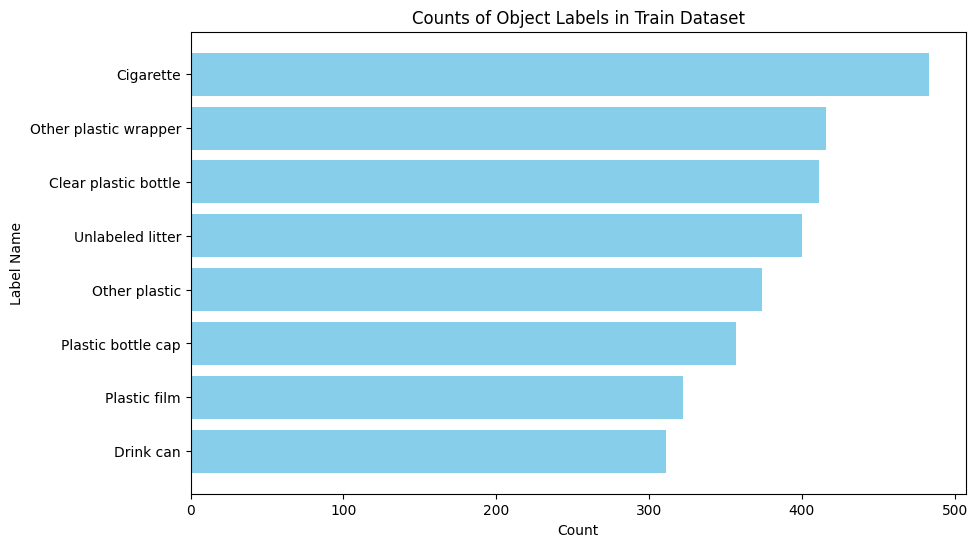

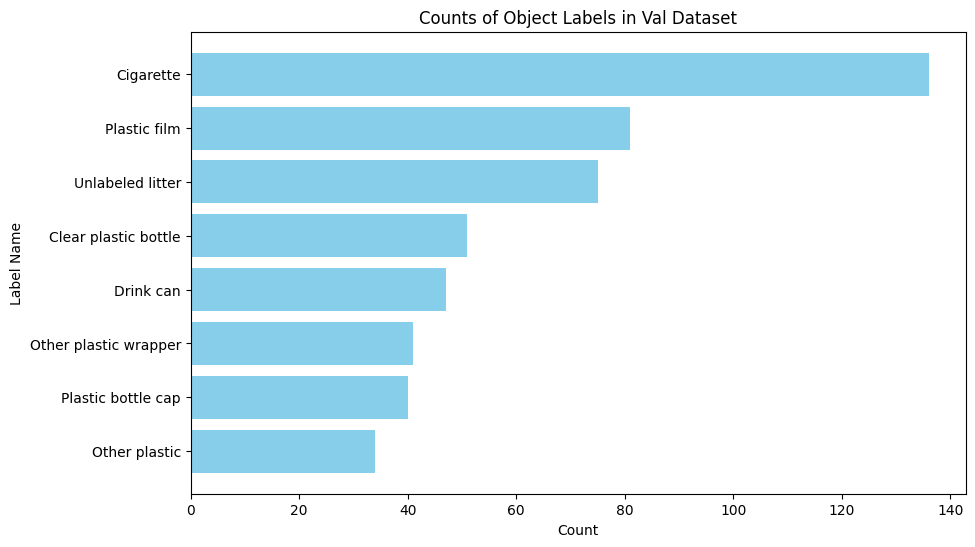

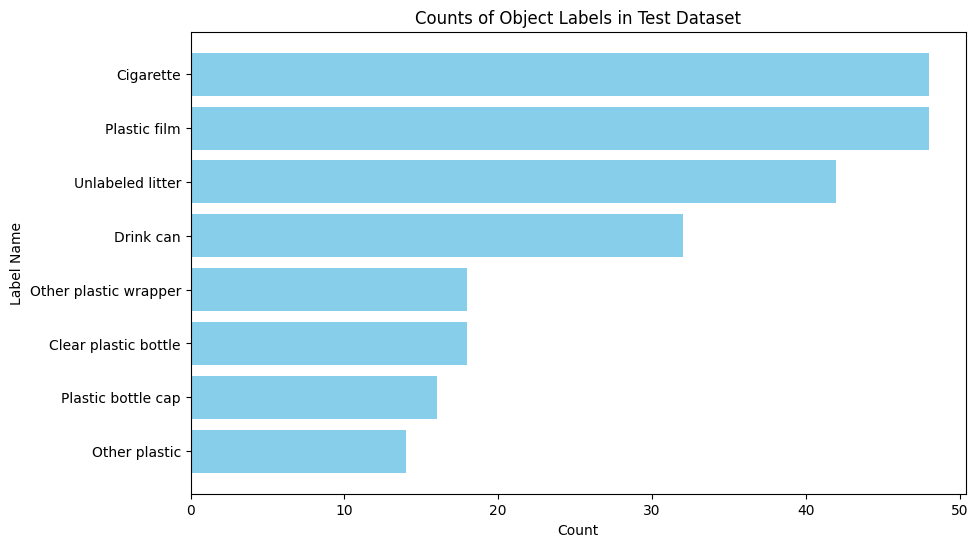

In [17]:
import matplotlib.pyplot as plt

# Define a mapping from label IDs to names
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Other plastic",
    7: "Drink can"
}


# Function to plot label counts for a given split
def plot_label_counts(split, label_counts):
    # Convert label IDs to label names and sort by count
    labels, counts = zip(*sorted(
        [(label_names[label_id], count) for label_id, count in label_counts.items()],
        key=lambda x: x[1]
    ))

    # Plotting a horizontal bar chart for the split
    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='skyblue')
    plt.xlabel("Count")
    plt.ylabel("Label Name")
    plt.title(f"Counts of Object Labels in {split.capitalize()} Dataset")
    plt.show()

# Loop through each split and calculate label distributions
for split in ['train', 'val', 'test']:
    label_dir_split = os.path.join(base_dir, split, 'labels')

    # Initialize a counter for label counts for the current split
    label_counts = Counter()

    # Loop over each label file in the current label directory
    for label_file in os.listdir(label_dir_split):
        label_file_path = os.path.join(label_dir_split, label_file)

        # Read the label file
        with open(label_file_path, 'r') as file:
            lines = file.readlines()

            # Count each label in the file
            for line in lines:
                parts = line.strip().split()
                label_id = int(parts[0])  # The label ID is the first element
                label_counts[label_id] += 1

    # Plot label counts for the current split
    plot_label_counts(split, label_counts)


In [18]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 52.7 MB/s eta 0:00:00


In [37]:
import yaml
import os

if os.path.exists('data.yaml'):
  os.remove('data.yaml')

# Define the data you want to write to the YAML file
data = {
    'path': '/content//yolo_top_categories/',  # Replace with your actual path
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {
        '0': 'Plastic film',
        '1': 'Unlabeled litter',
        '2': 'Cigarette',
        '3': 'Clear plastic bottle',
        '4': 'Plastic bottle cap',
        '5': 'Other plastic wrapper',
        '6': 'Other plastic',
        '7': 'Drink can'
    }
}

# Specify the path and filename for the YAML file
data_file_path = 'data.yaml'  # Change to your desired path and filename

# Write the data to the YAML file
with open(data_file_path, 'a') as yaml_file:
    yaml.dump(data, yaml_file, indent=2)  # Use indent for better readability

print(f"YAML file '{data_file_path}' created successfully.")

YAML file 'data.yaml' created successfully.


In [39]:
import yaml
import os

if os.path.exists('hyp.yaml'):
  os.remove('hyp.yaml')

# Define the data you want to write to the YAML file
data = {
    'epochs': 100,
    'imgsz': 1536,
    'batch': 16,
    'patience': 15,
    'freeze': 10,
    'augment': False,
}

# Specify the path and filename for the YAML file
hyp_file_path = 'hyp.yaml'  # Change to your desired path and filename

# Write the data to the YAML file
with open(hyp_file_path, 'a') as yaml_file:
    yaml.dump(data, yaml_file, indent=2)  # Use indent for better readability

print(f"YAML file '{hyp_file_path}' created successfully.")

YAML file 'hyp.yaml' created successfully.


In [41]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8l.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data=data_file_path, cfg=hyp_file_path)

100%|██████████| 83.7M/83.7M [00:00<00:00, 327MB/s]


Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=1536, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/yolo_top_categories/train/labels.cache... 1316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1316/1316 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_top_categories/val/labels.cache... 217 images, 0 backgrounds, 0 corrupt: 100%|██████████| 217/217 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1536 train, 1536 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      20.4G     0.9564      4.368      1.221         17       1536: 100%|██████████| 83/83 [02:22<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]

                   all        217        505     0.0493      0.359     0.0309     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      21.8G      1.089      2.483      1.296         14       1536: 100%|██████████| 83/83 [02:21<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]

                   all        217        505      0.238      0.258      0.121     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      20.1G      1.125       2.12      1.289         27       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all        217        505       0.28        0.3      0.206      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      21.8G      1.093      1.968       1.26         15       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        217        505       0.26      0.373      0.258      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      20.5G      1.024      1.662      1.228          6       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all        217        505      0.378      0.286      0.262      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      20.8G     0.9767      1.563      1.189         19       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]

                   all        217        505      0.346      0.345      0.286      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      21.9G     0.9469      1.417      1.164          9       1536: 100%|██████████| 83/83 [02:21<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        217        505      0.354      0.356      0.291      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      21.9G     0.8895      1.319      1.127         14       1536: 100%|██████████| 83/83 [02:21<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]

                   all        217        505      0.393      0.347        0.3      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      19.8G     0.8388      1.199      1.118         13       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.352      0.367      0.313      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      20.5G     0.8519      1.163      1.111          7       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.327      0.344      0.295      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      20.8G     0.8091      1.108        1.1         12       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.359      0.371       0.33      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      21.4G     0.7715      1.024      1.055         26       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.401      0.362      0.326       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      20.5G      0.766     0.9679      1.065         14       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.376      0.386      0.315      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      20.7G     0.7588      0.912      1.059         15       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.377       0.38      0.324      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      21.1G     0.7418     0.8794      1.048         13       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.329      0.378      0.305      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      20.4G     0.7426     0.8827      1.035         11       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.384      0.371      0.326      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      21.3G     0.7345     0.8547      1.036         16       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.378      0.377      0.311      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      20.6G     0.6963     0.8163      1.037         30       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.453      0.334      0.326      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      20.8G      0.697     0.7785      1.009         11       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.393      0.355      0.331      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      20.8G     0.6761     0.7281       1.01         14       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.373        0.4      0.345      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      21.3G     0.6732     0.7101     0.9977          7       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505       0.46      0.323      0.329      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      21.4G     0.6685     0.7106      1.005          7       1536: 100%|██████████| 83/83 [02:20<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.365      0.375      0.317      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      20.2G     0.6374     0.6659     0.9833         12       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.353      0.393      0.335      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      20.7G     0.6562     0.6828     0.9899         28       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505       0.36      0.371       0.31      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      20.3G     0.6203     0.6557     0.9841          8       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.393      0.356      0.326      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      21.3G     0.6119     0.6212     0.9767         10       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.463      0.336      0.329       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      21.8G     0.6253     0.6385     0.9768         12       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.57s/it]

                   all        217        505      0.422      0.358      0.329      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      21.1G     0.6059     0.5841     0.9576         18       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.405      0.406      0.337      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100        21G     0.6017     0.5884     0.9646          8       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.359      0.402      0.319      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      20.1G     0.6036     0.5761     0.9568         32       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.403      0.376      0.351      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      20.7G     0.5842     0.5656     0.9627         17       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505        0.4      0.383      0.327      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      21.6G     0.5849     0.5635     0.9473          7       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        217        505      0.429      0.387       0.34      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      20.9G     0.5757     0.5701      0.951         10       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.418       0.36       0.32      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      20.2G     0.5644     0.5335     0.9468         19       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505       0.46      0.366      0.344      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      21.4G     0.5663     0.5193      0.937          9       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.405      0.382      0.325      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      21.5G     0.5801     0.5452     0.9573         12       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.442      0.337      0.337      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      20.5G     0.5528     0.5166     0.9299         16       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.412      0.355      0.323      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      22.2G     0.5487     0.5003     0.9294         19       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505       0.38      0.368      0.331      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      21.3G     0.5603     0.5342     0.9395         27       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.424      0.367      0.336      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      20.9G      0.546     0.5107     0.9216         14       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.352       0.36       0.31      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      19.9G     0.5368     0.4887     0.9269         22       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505       0.38      0.372       0.32      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      20.2G     0.5335     0.4855     0.9292         23       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.388      0.381      0.322      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100        20G     0.5287     0.4764     0.9339         10       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.456      0.335      0.341      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      21.8G     0.5235     0.4563     0.9232         14       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]

                   all        217        505      0.416      0.374      0.337      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      21.5G     0.5073     0.4532     0.9265         10       1536: 100%|██████████| 83/83 [02:20<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

                   all        217        505      0.397      0.371      0.334      0.262
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



45 epochs completed in 1.916 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 87.8MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 268 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


                   all        217        505      0.406      0.373      0.351      0.271
          Plastic film         52         81      0.489      0.296      0.275      0.192
      Unlabeled litter         51         75      0.218      0.107     0.0735     0.0423
             Cigarette         49        136       0.46       0.39      0.371      0.223
  Clear plastic bottle         45         51      0.512      0.762      0.702      0.583
    Plastic bottle cap         37         40      0.517      0.475      0.511      0.399
 Other plastic wrapper         28         41      0.211       0.22      0.194       0.13
         Other plastic         27         34       0.45      0.588      0.528      0.464
             Drink can         34         47      0.394      0.149      0.153      0.136
Speed: 0.7ms preprocess, 45.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train4
